In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


=3


이번 뉴스 요약본 익스 노드에서는 nltk를 사용한다고 한다.
nltk는 Natural Language Toolkit의 약자로 영어, 통계, 자연어를 처리하기 위한 라이브러리라고 한다.
그래서 가장 먼저 nltk를 다운받아 주고, 나머지 데이터 처리를 위한 패키지도 불러와준다.

In [2]:
data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summary_more.csv", nrows=100000)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


여기서 10만개 정도의 샘플을 불러와보면 전체 샘플수는 98401개로 나온다.

In [3]:
!pip install --upgrade gensim==3.8.3

     |████████████████████████████████| 23.4 MB 5.7 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for gensim: filename=gensim-3.8.3-cp39-cp39-linux_x86_64.whl size=24328218 sha256=3901aebf1ec288dc45f61495a54ec025bd68425aee765c4b1a98a457a370d7a3
  Stored in directory: /aiffel/.cache/pip/wheels/ca/5d/af/618594ec2f28608c1d6ee7d2b7e95a3e9b06551e3b80a491d6
Successfully built gensim
  Attempting uninstall: gensim
    Found existing installation: gensim 4.1.2
    Uninstalling gensim-4.1.2:
      Successfully uninstalled gensim-4.1.2


아 여기서 겐심을 다운받았는데, 겐심은 주제 모델링 , 문서 인덱싱 및 대규모 말뭉침의 유사성 검색을 위한 파이썬 라이브러리라고 한다. 대상은 자연어 처리 및 정보 검색 커뮤니티라고 하는데, 사실 다른 분께 질문을 했을 때 이거 다운받아야 나중에 오류가 안뜬다고 해서 받았다.

In [4]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


데이터를 불러오면, 기존 연습에서 여러가지 뜬것에 반해 headlines와 text만 떴다.

In [5]:
data = data[['headlines','text']]
data.head()

#랜덤한 15개 샘플 출력
data.sample(10)

,headlines,text
66265,Paytm Mall posts â¹13.63 crore net loss for 2...,"Paytm Mall, operated by digital payments start..."
24940,Akshay thanks govt for exempting sanitary pads...,Actor Akshay Kumar has thanked the GST Council...
79541,"Don't support vigilantism, law-order state iss...",As the Supreme Court (SC) was hearing a petiti...
2653,K'taka auto driver killed by another driver fo...,Karnataka's 67-year-old autorickshaw driver Na...
11214,"RBI is not truly, truly independent: PM advise...","The RBI isn't ""truly, truly independent"" as mo..."
47711,Farah turned down chance to choreograph DDLJ s...,Filmmaker Karan Johar has revealed Farah Khan ...
44833,Parents donate organs after 8-yr-old dies of b...,"The parents of an eight-year-old girl, who was..."
46464,PM favoured private diamond firms against publ...,Congress leader Anand Sharma has accused Prime...
94533,Dwayne has got only one Vin in his life: Vin D...,"Vin Diesel, while explaining that his feud wit..."
9745,I was first offered Salman's role in Maine Pya...,Actor Piyush Mishra has revealed that he was i...


이 데이터들 중에 샘플로 10개를 뽑으면 위와같은 결과가 나온다.

In [6]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98280
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98360


그런데 데이터들 중에서 중복된 것들이 있을 수 있으니 제거를 해주면
위와 같은 수가 나온다.
근데 전체 샘플 수에 비해서 그렇게 제거된건 없는거 같다.

In [7]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['headlines'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98280


이것도 중복을 제거하는 방법인데, data.drop_duplicates이걸 쓰면 한줄로 끝낼 수 있어서 간편하다.

In [8]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


중복을 제거했지만, Null값이 남아있을 수 있으니 한번 확인해봤다.
근데 하나도 없다.

In [9]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98280


그래서 여기서 또 확인해도 위에 전체 샘플수와 같다.

In [10]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


텍스트를 정규화 시켜줘서 연산량을 줄여준다.

In [11]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

일반적인 텍스트에서는 자주 나오지만, 자연어를 처리할 때 실질적으로 별 도움이 되지 않는 단어들이 존재한다고 한다.
이런것들을 불용어라고 하는데 이 불용어들을 확인해보니 179개가 있다.

In [12]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (text)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


방금 위에서 확인했던 불용어들을 제거한다.
요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 text에는 남아 있는게 더 좋을거 같다고 생각이 들어 함수 인자
remove_stopwords를 추가하고 거기에 if를 추가하였다.

In [13]:
temp_headlines = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_text = 'Great way to start (or finish) the day!!!'

print("headlines: ", preprocess_sentence(temp_headlines))
print("text:", preprocess_sentence(temp_text, False))  # 불용어를 제거하지 않습니다.

headlines:  everything bought great infact ordered twice third ordered wasfor mother father
text: great way to start the day


불용어를 제거 한 후 headlines과 text를 불러내서 결과를 확인해 보았다.
알파벳들이 다 소문자고, 아까 위에서 불러냈을 때 봤었던 이상한 문양같은게 없다.

In [14]:
clean_headlines = []
# 전체 headlines 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s))

# 전처리 후 출력
print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches career ml al salary hike', 'delhi techie wins free food swiggy one year cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'known hirani yrs metoo claims true sonam']


방금까지 잘 작동된거 같으니, 훈련 데이터 전체에 대해 전처리를 해볼 것이다.
그런데 headlines만 불용어를 제거하고 text는 아직 제거하지 않을거니깐 따로따로 호출을 할 것이다.
그러므로 먼저 headlines부터 불러내서 전처리를 한 후에 위에서부터 5개를 출력해 보았다.

In [15]:
clean_text = []
# 전체 text 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s, False))

print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant an alumnus of upgrad and iiit pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad degree career support helped him transition to data scientist at tech mahindra with salary hike upgrad online power learning has powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance to win free food from swiggy for one year pranav kaushik delhi techie bagged this reward after spending cred coins users get one cred coin per rupee of bill paid which can be used to avail rewards from brands like ixigo bookmyshow ubereats cult fit and more', 'new zealand defeated india by wickets in the fourth odi at hamilton on thursday to win their first match of the five match odi series india lost an international match under rohit sharma captaincy after consecutive victories dating back to march the match witnessed india getting all out for their sevent

위에 headlines을 했으니 이번엔 text로 해봤다.
text가 훨씬 길게 출력되었다.

In [16]:
data['headlines'] = clean_headlines
data['text'] = clean_text

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


이렇게 위에서 전처리 과정을 한 후에 빈칸이 있을 수 있으니 빈칸을 Null로 변환시켰다.

In [17]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

그 다음 그 null값이 몇개나 있나 한번 확인해 봤는데 하나도 없다.

In [18]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98280


그래서 전체 샘플수는 아까랑 같은 98280

헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 13
헤드라인의 평균 길이 : 7.1367317867317865
텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 69
텍스트의 평균 길이 : 56.18174603174603


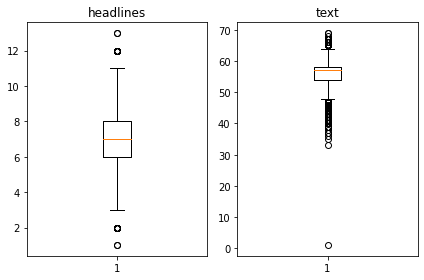

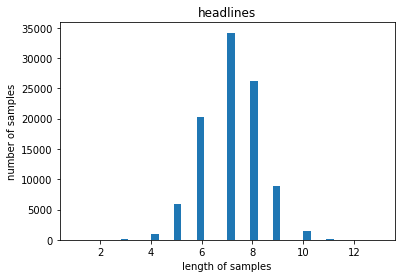

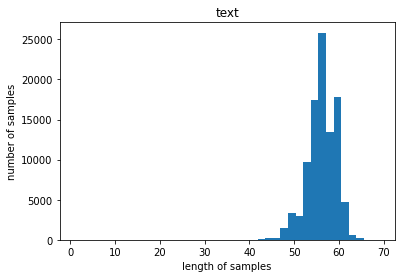

In [66]:
# 길이 분포 출력
import matplotlib.pyplot as plt

headlines_len = [len(s.split()) for s in data['headlines']]
text_len = [len(s.split()) for s in data['text']]

print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))
print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

아까 전처리를 하고 null값을 제거하면서 데이터를 정리해봤는데, 샘플의 문장 길이가 어느정도 되는지 한번 확인해 보았다.
그래프를 이용해서 봤는데, 헤드라인은 최대 길이가 13이고 평균적으로 7.13정도 된다.
텍스트의 최대 길이는 69고 평균은 59.1817이 나왔다.

In [20]:
headlines_max_len = 13
text_max_len = 69
print('=3')

=3


그래서 이번에 그래프에서 보던 최대길이로 헤드라인과 텍스트의 길이를 정해놨다.

In [21]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


위에서 길이를 정한다음 그 퍼센테이지를 확인해보기 위해 식을 적었다.

In [22]:
below_threshold_len(headlines_max_len, data['headlines'])
below_threshold_len(text_max_len,  data['text'])

전체 샘플 중 길이가 13 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 69 이하인 샘플의 비율: 1.0


당연히 둘다 1인게 그래프에서 보았던 최대값을 내가 최대값 설정을 할 때 넣었으니 그 안에 그래프 안에 있던 모든 값이 
다 들어있어서 1이 나온것이다.

In [23]:
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98280


그래서 샘플수도 똑같이 나왔다.

In [24]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['text'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['text'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches career ml al salary hike,saurav kant an alumnus of upgrad and iiit pg p...,sostoken saurav kant an alumnus of upgrad and ...,saurav kant an alumnus of upgrad and iiit pg p...
1,delhi techie wins free food swiggy one year cred,kunal shah credit card bill payment platform c...,sostoken kunal shah credit card bill payment p...,kunal shah credit card bill payment platform c...
2,new zealand end rohit sharma led india match w...,new zealand defeated india by wickets in the f...,sostoken new zealand defeated india by wickets...,new zealand defeated india by wickets in the f...
3,aegon life iterm insurance plan helps customer...,with aegon life iterm insurance plan customers...,sostoken with aegon life iterm insurance plan ...,with aegon life iterm insurance plan customers...
4,known hirani yrs metoo claims true sonam,speaking about the sexual harassment allegatio...,sostoken speaking about the sexual harassment ...,speaking about the sexual harassment allegatio...


그래서 여기서 정해진 길이가 나올 때 연습에서는 기존에 값보다 길면 제외를 시켰지만, 나는 가장 최대로해서 제외된게 없다.

In [25]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


인코더의 입력과 디코더의 입력, 레이블을 Numpy타입으로 저장해본다.

In [26]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[19550  3034 48084 ... 54897 19303 81939]


encoder의 input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들어보자.

In [27]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


정수 시퀀스를 이용해서 데이터의 샘플 순서를 정의해 주자.

In [28]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19656


훈련과 테스트 데이터의 비율을 8:2로 나눠보았는데
테스트 데이터 수가 19656개가 나왔다.

In [29]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78624
훈련 레이블의 개수 : 78624
테스트 데이터의 개수 : 19656
테스트 레이블의 개수 : 19656


나눠진 숫자를 보면 잘 나온거 같다.

In [30]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


기계가 텍스트를 숫자로 처리할 수 있게 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꿔줘야 한다고 한다.
이것을 위해서 각 단어에 고유한 맵핑을 해야되는데 이 과정을 단어 집합이라고 하고, 이것을 해보기 위해 encoder_input_train에 대한 단어집합을
만들어 보았다.

In [31]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69693
등장 빈도가 6번 이하인 희귀 단어의 수: 47467
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22226
단어 집합에서 희귀 단어의 비율: 68.10870532191181
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.180865141861739


단어 집합이 만들어지고 고유한 정수가 붙었다. 그리고 만들어진 단어 집합은 src_tokenizer.word_index에 저장되어 있다고 한다.
그런데 단어 집합에 있는 모든 단어를 사용할 것이 아니기 때문에 등장 빈도수가 적은것들을 제외해보려고 한다.
7회 미만인 단어들을 찾아 얼마만큼의 비율을 차지하는지 한번 확인해보았다.
68퍼센트 정도 나온것을 보면 중간보다 좀더 많이 있는걸 확인할 수 있다.

In [32]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


texts_to_sequences()는 생성된 단어집합에 기반해서 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행한다고 한다. 지금 src_vocab = 8000이걸로 단어 집합의 크기를 8000으로 제한했기 때문에 8000이 넘는 숫자들은 정수 인코딩 후 존재하지 않는다고 한다.

In [33]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[5621, 6439, 6, 120, 1391, 2, 2160, 1551, 3, 1, 112, 1263, 22, 999, 632, 15, 36, 1, 30, 54, 407, 1, 46, 52, 129, 177, 3, 2, 312, 1016, 3, 358, 5, 1885, 22, 696, 1281, 4, 999, 632, 41, 27, 241, 1551, 3, 352, 6, 156], [2167, 992, 1, 30, 54, 647, 237, 28, 4789, 8, 4355, 18, 1515, 3, 6003, 417, 785, 869, 388, 1, 417, 140, 1, 1461, 4, 490, 5578, 599, 4941, 157, 9, 1, 9, 32, 4355, 1007, 71, 178, 238, 203, 2, 24, 41, 2133, 32, 184, 3, 6058, 1640, 94, 4, 2137, 5, 4200, 1641], [2119, 18, 82, 68, 4, 496, 45, 1352, 21, 670, 136, 1, 679, 320, 7, 9, 3, 37, 230, 2223, 22, 1, 6058, 200, 1386, 8, 1, 4, 2119, 1, 320, 9, 10, 1, 2002, 989, 4899, 1019, 3112, 423, 5, 862, 275, 301, 2119, 732, 959, 38, 1352, 3, 442]]


정수 인코딩을 하니까 아까 위에서는 텍스트로 나왔었는데 이제는 숫자로 나온다.

In [34]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


케라스 토크나이저를 사용해서 decoder_input_train을 입력해 전체 단어 집합과 각 단어에 대한 빈도수를 계산 할 수 있다.

In [35]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69694
등장 빈도가 5번 이하인 희귀 단어의 수: 45626
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 24068
단어 집합에서 희귀 단어의 비율: 65.46618073291819
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8970102291293838


아까 위에서 했던것처럼 등장빈도가 낮은 것들의 비율이 얼마나 나올지 또 확인해보는 건데 이번엔 6회 미만인 것들을 확인해 보았다.
아니다 지금보니까 비율이 65정도 되는거면 중상정도의 비율을 가지고 있는것을 볼 수 있다.

In [36]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[11, 6, 122, 1393, 2, 1553, 3, 1, 114, 1265, 24, 1001, 634, 17, 38, 1, 32, 56, 409, 1, 48, 54, 131, 179, 3, 2, 314, 1018, 3, 360, 5, 1887, 24, 698, 1283, 4, 1001, 634, 43, 29, 243, 1553, 3, 354, 6, 158], [11, 994, 1, 32, 56, 649, 239, 30, 8, 20, 1517, 3, 419, 787, 871, 390, 1, 419, 142, 1, 1463, 4, 492, 601, 159, 9, 1, 9, 34, 1009, 73, 180, 240, 205, 2, 26, 43, 34, 186, 3, 1642, 96, 4, 5, 1643], [11, 20, 84, 70, 4, 498, 47, 1354, 23, 672, 138, 1, 681, 322, 7, 9, 3, 39, 232, 24, 1, 202, 1388, 8, 1, 4, 1, 322, 9, 10, 1, 991, 1021, 425, 5, 864, 277, 303, 734, 961, 40, 1354, 3, 444], [11, 699, 1245, 57, 6, 125, 289, 25, 24, 1, 1531, 24, 1215, 255, 307, 1066, 565, 1, 7, 35, 210, 67, 241, 213, 5, 2, 706, 5, 1766, 213, 2, 51, 8, 460, 134, 37, 2, 1454, 2, 1833, 1766, 5, 1531, 1500], [11, 657, 140, 30, 119, 588, 652, 17, 9, 51, 1, 10, 198, 518, 2, 26, 1, 189, 518, 376, 105, 27, 487, 692, 516, 5, 1821, 2, 26, 22, 22, 82, 17, 1, 288, 86, 195, 5, 1757, 22, 417, 5, 86, 28, 2, 180, 19,

이번에는 2000을 최대로 해서 다시 정수 인코딩을 했을 때의 결과값들이다.

In [37]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78623
훈련 레이블의 개수 : 78623
테스트 데이터의 개수 : 19656
테스트 레이블의 개수 : 19656


훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장해보았다.
흠... 근데 보면 훈련데이터에서 삭제한건 1개고 테스트 데이터에서 삭제한건 없다.

In [38]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=headlines_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=text_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=text_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=text_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=text_max_len, padding='post')
print('=3')

=3


텍스트 시퀀스를 정수 시퀀스로 변화시켜줬으니까 이제 서로 다른 길이의 샘플들을 병렬처리 해주었다.(패딩작업)
아까 정해뒀던 최대길이로 패딩작업을 하고, 최대 길이에 맞추지 못한 짧은 데이터들은 뒤에 0을 넣어 최대길이에 맞춰준다.

In [39]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(headlines_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

아까까지 데이터를 정리했으니 이제는 모델을 만들어 볼 차례다.
여기서  hidden state는 LSTM에서 얼만큼의 수용력을 가질지 정하는 파라미터라고 한다.
이 파라미터는 LSTM의 용량크기, 뉴런의 개수라고 이해하면 된다고 한다.
LSTM은 dropout 뿐 아니라 recurrent dropout까지 사용하는데 일반적인 dropout은 레이어의 weight를 랜덤으로 생략하여 모델의 과적합을 해결해준다고 한다.

In [40]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

디코더의 임배딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일하다고 한다.
LSTM의 값을 정의할 때 initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어야 한다고 한다.

In [41]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 13)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 13, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 13, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

디코더의 출력층에서는 Summary의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야한다. 그렇기 때문에 Dense의 인자로 tar_vocab을 주고, 활성화 함수로 소프트맥스 함수를 사용한다고 한다.
이게 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 seq2seq라고 한다.

In [42]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 13)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 13, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 13, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

어텐션 층을 만든다음, 아까 위에서 만든 디코더의 출력층을 수정해보았다.

In [43]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 158s 462ms/step - loss: 3.8701 - val_loss: 3.4665
Epoch 2/50
308/308 [==============================] - 140s 454ms/step - loss: 3.2910 - val_loss: 3.1532
Epoch 3/50
308/308 [==============================] - 139s 450ms/step - loss: 3.0693 - val_loss: 2.9993
Epoch 4/50
308/308 [==============================] - 138s 449ms/step - loss: 2.9439 - val_loss: 2.8942
Epoch 5/50
308/308 [==============================] - 138s 450ms/step - loss: 2.8585 - val_loss: 2.8216
Epoch 6/50
308/308 [==============================] - 138s 448ms/step - loss: 2.7945 - val_loss: 2.7689
Epoch 7/50
308/308 [==============================] - 139s 453ms/step - loss: 2.7428 - val_loss: 2.7259
Epoch 8/50
308/308 [==============================] - 139s 453ms/step - loss: 2.6994 - val_loss: 2.6945
Epoch 9/50
308/308 [==============================] - 140s 454ms/step - loss: 2.6613 - val_loss: 2.6547
Epoch 10/50
308/308 [==============================] - 139s 452m

이거 훈련 진행하는데 early stopping이거 있으면 조건이 충족되었을 시 남은횟수와 상관없이 종료한다.
근데 이거 거의 끝자락에서 종료해서 한두시간 잡아먹은거 같다.

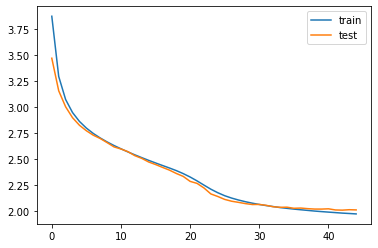

In [44]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

훈련 데이터와 테스트 데이터 손실이 줄어드는거 그래프로 보는데 거의 똑같은거 같다.

In [45]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하기 때문에, 필요한 3개의 사전을 준비해준다.

In [46]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


아까 훈련단계에서 디코더 입력부에 정답이 되는 문장 전체를 한번에 넣고 디코더의 출력과 한번에 비교할 수 있어서 인코더와 디코더를 한번에 넣었지만, 이건 정답이 없는 인퍼런스 단계이므로 인코더모델만 따로 분리해서 설계해야 한다.

In [47]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(headlines_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


여기서는 어텐션 함수를 이용해서 출력층을 설계했다.

In [57]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (text_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


인퍼런스 단계에서 단어 시퀀스를 완성하는 함수

In [58]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


 함수를 만들 때, headlines의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고 text의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만들어보자.

In [59]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, headlines_max_len)))
    print("\n")

원문 : want is that yes there is sense beyond that it is just conversation 
실제 요약 : actress anushka sharma has said one cannot actors or star kids for when am working with star or non star am not that the other person is working any less added anushka she further said all that people want is that there is that it is just 
예측 요약 :  actor has said that he is not to be as the film is not the film is not he added that he is not the film is not the film is not he added further said that there is that there is that there is that there is that it is just


원문 : release on october will mark the first collaboration of with ayushmann and tabu 
실제 요약 : the trailer of and starrer has been released the role of player while his love interest in the film directed by the film is scheduled to release on october will mark the first of with and 
예측 요약 :  actor ajay has said that he will not be able to play the film as per reports the film will be produced by the film which will be produced by and directed 

테스트 데이터 50개 샘플에 대해서 출력해 보았다.
근데 영어라서 맞게 나온건가..?

In [60]:
import requests
from summa.summarizer import summarize

In [61]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [62]:
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

In [63]:
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [64]:
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


In [65]:
print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


영화 매트릭스에 대한 뉴스 요약봇의 결과들이 나왔다.
이번 익스 노드를 하면서, 처음부터 내가 맞게 한건가란 생각이 들었고, 진구님한테
귀찮을 정도로 질문을 많이 했는데, 친절하게 자세하게 도움을 받을 수 있었다.